# What is this notebook? 
This is my attempt to write a _clear_ and _understandable_ tutorial on language modeling using Transformers. 

Why another tutorial when everybody and their cats are writing Transformer and language modeling tutorials? Every tutorial I found skips on some important explanations that I had to think about to understand. How exactly does masking work in self attention? How is a vocabulary buit? How the heck does language generation actually work during inference time? Jut given a raw corpus, how can I build a language generator? Every existing codebase is too complicated with layers of abstractions that I am too lazy to parse through. 

Admittedly, this might not be the best of the best out there, but I try to build stuff from scratch to get a minimal understanding of everything. 

In [66]:
!nvidia-smi

Thu Mar 10 07:09:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    58W / 149W |  11137MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [67]:
import math 
import torch 
import numpy as np 
from torchtext.datasets import WikiText2
from collections import Counter, OrderedDict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [68]:
def tokenize(sentence):
  # Simple white space tokenizer 
  return sentence.strip().split()
  
# Tokenize each document in the training set 
# WikiText2 has a bunch of documents, each document has some x number of tokens 
train_iter, val_iter, test_iter = WikiText2()
tokenized_train_iter = map(tokenize, train_iter)
tokenized_val_iter = map(tokenize, val_iter)
tokenized_test_iter = map(tokenize, test_iter)

In [69]:
min_freq = 10 # minimum freqency of occurance to be included in the vocab 
special_tokens = ["<unk>", "<pad>"]

# Simple vocabulary class 
class vocab():
  """
  A simple vocab class to build a vocab from an interator of tokens. 
  To the point, what am I doing here 
    * Make a set of words from the iterator 
    * Count how many times each word occurs 
    * Sort them based on their count 
    * If a word occurs more than some x times, add it to vocab 
    * Pick top k if you have a k in mind 
    * Add special tokens and make <unk> as default for words not in vocab 
    * Have functions to convert ids to tokens and vice versa 
  """
  def __init__(self, iterator, special_tokens=None):
    self.default_key = 0 
    counter = Counter() 
    # Count the number of occurances in each token 
    for token in iterator:
      counter.update(token) 
    # Sort the counter and then filter 
    sorted_counter = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    # Make it an ordered dict 
    sorted_counter = OrderedDict(sorted_counter) 

    # Pop the special tokens from counter if they already exist 
    token_set = []
    if special_tokens:
      for special_token in special_tokens:
        sorted_counter.pop(special_token, None)
        token_set.append(special_token)

    # If greater than min freq then add to token set 
    for token, count in sorted_counter.items():
      if count >= min_freq:
        token_set.append(token)
    
    self.vocab_size = len(token_set)
    self.token2id_map = {token:id for id, token in enumerate(token_set)}
    self.id2token_map = {id:token for id, token in enumerate(token_set)}

  def itos(self, indices):
    # Function to convert a list of indices to list of tokens 
    return [self.id2token_map.get(idx) for idx in indices]
  
  def stoi(self, token_list):
    # Function to convert token list to list of indices.
    # Default to 0 if it's not in voab 
    return [self.token2id_map.get(token, 0) for token in token_list]

In [70]:
v = vocab(tokenized_train_iter, special_tokens)
vocab_size = v.vocab_size 

In [71]:
# The iterators are consumed, load again 
# WikiText2 has a bunch of documents, each document has some x number of tokens 
train_iter, val_iter, test_iter = WikiText2()
tokenized_train_iter = map(tokenize, train_iter)
tokenized_val_iter = map(tokenize, val_iter)
tokenized_test_iter = map(tokenize, test_iter)

# convert each token in dataset to tensor 
train_tokens, test_tokens, val_tokens = [], [], [] 
for sample in tokenized_train_iter:
  train_tokens.append(torch.tensor(v.stoi(sample), dtype=torch.long))

for sample in tokenized_val_iter:
  val_tokens.append(torch.tensor(v.stoi(sample), dtype=torch.long))

for sample in tokenized_test_iter:
  test_tokens.append(torch.tensor(v.stoi(sample), dtype=torch.long))

# Combine all train documents a single long set of tokens. 
# Imp Note : the order of the tokens must be preserved 
train_set = torch.cat(tuple(filter(lambda t: t.numel() > 0, train_tokens)))
val_set = torch.cat(tuple(filter(lambda t: t.numel() > 0, val_tokens)))
test_set = torch.cat(tuple(filter(lambda t: t.numel() > 0, test_tokens)))

def batchify(data, bsz):
  """Divides the data into bsz separate sequences, removing extra elements
  that wouldn't cleanly fit.

  Args:
      data: Tensor, shape [N]
      bsz: int, batch size

  Returns:
      Tensor of shape [N // bsz, bsz]
  """
  seq_len = data.size(0) // bsz
  data = data[:seq_len * bsz]
  data = data.view(bsz, seq_len).t().contiguous()
  return data.to(device)
  

batch_size = 32
eval_batch_size = 32
train_data = batchify(train_set, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_set, eval_batch_size) 
test_data = batchify(test_set, eval_batch_size)

# Batching 
Alright, this is one thing that I was confused about in the official pytorch language modeling tutorial. How exactly is the dataset being partitioned and why the heck is batch size so low? I found the diagram of 1D convolution an easy way to understand what's happening here. 

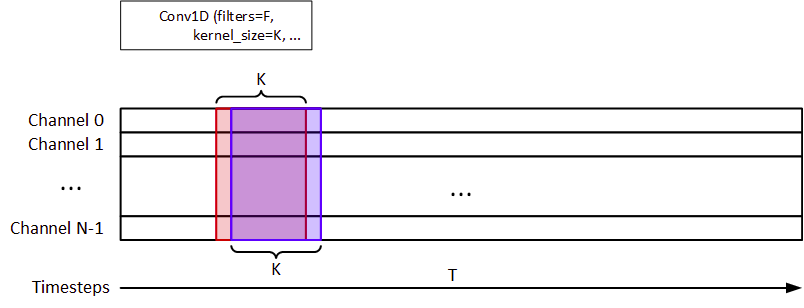

Let's say we have a looooong sequence of tokens, a language model basically looks at a sequence of tokens and predicts the next token, right? But the question is, how long back in history should we go back? Going back all the way to the starting of the sequence might make learning hard if the sequence is super long. Also, the self attention mechanism complexity is O(n^{2}). It rises up _super_ quickly. So we take a window. We slide that window over the sequence and predict the next word for each context. 

For example, let's say our sequence is A B C D E F G, and out window size is 3. Our first sample is A B C and the correspondings targets are B C D. Given A, predict B. Given A B, predict C. Given A B C, predict D. How do we impart this autoregressive property? More on that later. 

Back to Batching: We can improve the speed of our training by breaking the entire sequence into multiple parallel sequence. We los the connection between sequences, but that's relatively small compared to the dataset sizes we have. This interpretation sort of swaps the axes. For example, usually, our input tensors will have the shape (batch_size, input dims**). Each element in the batch_size dimension is independent. 

Here, our input tensors have the shape (bptt_window_size, batch_size). The time dimension comes first, and elements in the first dimension are not independent of each other. 

In [72]:
# Let's define the transformer stuff, starting with multiheaded attention  
import torch.nn as nn 
import torch.nn.functional as F 

q_dim = 512
v_dim = 512
emb_dim = 256
n_heads = 4 
hidden_dim = 512

# Let's try to understand what's happening here 
def scaled_dot_prod_attention(q, k, v, mask=None):
  """
  shapes of the incoming tensors 
  q = [batch_size, num_heads, max_seq_len_t, q_dim] 
  k = [batch_size, num_heads, max_seq_len_i, k_dim]
  v = [batch_size, num_heads, max_seq_len_i, v_dim]
  
  Usually, k_dim and q_dim are equal, as we need to perform the dot product. 
  Also, max_seq_len of source and target need not be same.
  That is, the attention scores need not be a square matrix. In the general case it is of shape [max_seq_len, max_seq_len]
  However, we are training, say, a machine translation model, these lengths won't be same.
  So, in summary, V and K must have same number of tokens.

  The decoder of the transformer is a general case that is applicable in all scenarios 
  In decoder self attention, we use the target vector as q, k and v. Because we want to
  find how each token in the target is related to every other token. 
  During the encoder-decoder self attention, we want the q to be source tokens, k to be target tokens, 
  because we want to know how each token in the source is related to target. Then use those scores to update the
  representaiton of target. 

  Let's ignore batchsize and num_heads for now. 
  q = [seq_len_t, q_dim]
  k = [seq_len_i, k_dim] 
  v = [seq_len_i, v_dim]

  q_dim = k_dim 
  so attention scores = [seq_len_t, seq_len_i]
  output = scores * v = [seq_len_t, seq_len_i] * [seq_len_i, hidden_dim]
  So for each dimension in hidden_dim, we take the weighted sum of input based on attention scores 
  """
  k_dim = k.shape[-1] 
  dot_prods = torch.matmul(q, torch.transpose(k, -2, -1)) # shape - [max_seq_len_i, max_seq_len_t]
  # The above dot product might push values high really quicky, and thus enter regions in
  # softmax where the gradients are not that informative. So we divide with dimension to scale 
  dot_prods /= math.sqrt(k_dim) 
  """
  Now, another important topic is masking of attention weights during self attention. 
  Let's say we are training a language model, that is, predict the next word given all previous words. 
  During training time, we of course have the entire sentence with us, but we can't use information 
  from the future. So we mask out subsequent positions. 

  The mask variable passed into this function is of shape [max_seq_len, max_seq_len] 
  The matrix has 0s in positions that must be masked out.
  Let's understand this with an example. 
  Let's say our input is [A B C D E] and our target is [B C D E F]. 
  Given A - Predict B 
  Given A B - predict C 
  Given A B C - predict D...
  So we see a traingular matrix here. Our mask for that example is gonna be 
  [1 0 0 0 0] -> value of a - score of a * value of a 
  [1 1 0 0 0] -> value value of b - score of a * value of a + score of b * value of b 
  [1 1 1 0 0]
  [1 1 1 1 0]
  [1 1 1 1 1]
  since we are adding this to the scores, our mask will be 
  [0 -inf -inf -inf]
  [0 0 -inf -inf -inf]
  ....
  """
  if mask is not None:
      dot_prods += mask 
  # use softmax to get the attention scores 
  attention_scores = F.softmax(dot_prods, dim=-1)
  # Now take the weight sum of values based on scores 
  output = torch.matmul(attention_scores, v) 
  return output

In [73]:
class MultiHeadAttention(nn.Module):
  def __init__(self):
    super(MultiHeadAttention, self).__init__()
    self.q_dim = q_dim 
    self.v_dim = v_dim 
    self.emd_dim = emb_dim

    # Linear projection layers 
    self.q_layer = nn.Linear(emb_dim, q_dim * n_heads)
    self.v_layer = nn.Linear(emb_dim, v_dim * n_heads)
    self.k_layer = nn.Linear(emb_dim, q_dim * n_heads)

    # Final linear layer 
    self.linear = nn.Linear(v_dim * n_heads, emb_dim)

  def forward(self, x, mask=None):
    # x shape - [batch_size, seq_len, emb_dim]
    batch = x.shape[0]
    seq_len = x.shape[1] 
    q = self.q_layer(x) # shape - [batch_size, seq_len, q_dim * n_heads]
    k = self.k_layer(x) # shape - [batch_size, seq_len, q_dim * n_heads]
    v = self.v_layer(x) # shape - [batch_size, seq_len, v_dim * n_heads]
    # reshape to make heads another dim 
    q = q.reshape(batch, n_heads, seq_len, -1)
    v = v.reshape(batch, n_heads, seq_len, -1)
    k = k.reshape(batch, n_heads, seq_len, -1)
    # multi headed attention 
    attention_output = scaled_dot_prod_attention(q, k, v, mask)
    attention_output = attention_output.reshape(batch, seq_len, -1)
    return self.linear(attention_output)
  
class LinearLayers(nn.Module):
  def __init__(self):
    super(LinearLayers, self).__init__() 
    self.linear1 = nn.Linear(emb_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, emb_dim)
    self.act = nn.ReLU() 
    
  def forward(self, x):
    return self.linear2(self.act(self.linear1(x)))

In [74]:
class DecoderLayer(nn.Module):
  def __init__(self):
    super(DecoderLayer, self).__init__()
    self.mha = MultiHeadAttention() 
    self.attention_norm = nn.LayerNorm(emb_dim) 
    self.linear = LinearLayers() 
    self.linear_norm = nn.LayerNorm(emb_dim) 

  def forward(self, x, mask):
    input = x 
    output = self.attention_norm(self.mha(x, mask))
    output = self.linear_norm(self.linear(output))
    return output + input

In [75]:
n_layers = 4 
class Transformer(nn.Module):
  def __init__(self):
    super(Transformer, self).__init__()
    self.embedding = nn.Embedding(vocab_size, emb_dim)
    self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
    self.final_layer = nn.Linear(emb_dim, vocab_size)
    self.pe = self.pos_encoding(bptt, emb_dim)

  def pos_encoding(self, seq_len, d_model):
    position = torch.arange(seq_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(seq_len, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)
    return pe.transpose(0, 1).to(device)

  def forward(self, x, attn_mask=None, pad_mask=None):
    # The functionality of pad_mask is explained later on with an example 
    x = self.embedding(x) 
    # Add pos encoding 
    x += self.pe[:, :x.size(1), :]
    if pad_mask is not None:
      x = x.masked_fill_(pad_mask == 1, 0)

    for layer in self.layers:
      x = layer(x, attn_mask) 
    prob_logits = self.final_layer(x) 
    return prob_logits

In [76]:
bptt = 512 # Backprop through time window 

def get_data(tensor, i, batch_first=True):
  # take chunks out of tensor starting from index i 
  chunk_size = min(bptt, len(tensor) -i - 1) # The final chunk might have less number than bptt window 
  inputs = tensor[i: i+chunk_size]
  # Flatten the target tensor, easy to calculate cross entropy loss
  targets = tensor[i+1: i+1+chunk_size].reshape(-1) 
  if batch_first:
    inputs = inputs.transpose(0, 1)
  return inputs, targets 

def get_mask(size):
  "Mask out subsequent positions."
  return torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)

In [77]:
# Now we have to write the training loop 

model = Transformer().to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

total_loss = 0 
total_ppl = 0 
log_interval = 50

# Eval function to eval on dev set 

def eval():
  step = 0 
  total_loss = 0 
  total_ppl = 0 
  model.eval() 
  # Sample from eval set 
  with torch.no_grad():
    for i in range(0, val_data.shape[0], bptt):
      step += 1 
      inputs, targets = get_data(val_data, i) 
      inputs, targets = inputs.to(device), targets.to(device) 
      mask = get_mask(min(bptt, len(val_data) -i -1)).to(device) 

      outputs = model(inputs, attn_mask=mask).reshape(-1, vocab_size)
      loss = criterion(outputs, targets)
      total_loss += loss.item() 
      total_ppl += math.exp(loss.item()) 
      avg_loss = total_loss / step 
      avg_ppl = total_ppl / step 

  print("Val: Avg Loss: {:.4f} Avg Ppl: {:.4f}".format(avg_loss, avg_ppl))

model.train() 
step = 0 
# Loop from start of the dataset to the final index with increments of bptt window size 
for epoch in range(1, 101):
  for i in range(0, train_data.shape[0], bptt):
    step += 1 
    # Get inputs and targets 
    inputs, targets = get_data(train_data, i)
    # Move to device 
    inputs, targets = inputs.to(device), targets.to(device) 
    mask = get_mask(min(bptt, len(train_data) -i - 1)).to(device) 

    model.zero_grad(set_to_none=True)
    outputs = model(inputs, attn_mask=mask).reshape(-1, vocab_size)
    loss = criterion(outputs, targets) 

    # backward pass 
    loss.backward() 
    optimizer.step()
    
    total_loss += loss.item() 
    total_ppl += math.exp(loss.item())
    if step % log_interval == 0:
      avg_loss = total_loss / step 
      avg_ppl = total_ppl / step 
      print("Train: Step: {} Avg Loss: {:.4f} Avg Ppl: {:.4f} ".format(step, avg_loss, avg_ppl))
      eval() # Evalvulate on val set 
  print("-----------")

Train: Step: 50 Avg Loss: 7.2369 Avg Ppl: 2766.2410 
Val: Avg Loss: 6.6930 Avg Ppl: 807.3660
Train: Step: 100 Avg Loss: 7.0476 Avg Ppl: 1859.3099 
Val: Avg Loss: 6.6526 Avg Ppl: 775.3015
-----------
Train: Step: 150 Avg Loss: 6.9535 Avg Ppl: 1529.4179 
Val: Avg Loss: 6.6231 Avg Ppl: 752.8101
Train: Step: 200 Avg Loss: 6.8836 Avg Ppl: 1345.0640 
Val: Avg Loss: 6.6213 Avg Ppl: 751.3554
Train: Step: 250 Avg Loss: 6.8424 Avg Ppl: 1234.9865 
Val: Avg Loss: 6.6043 Avg Ppl: 738.8779
-----------
Train: Step: 300 Avg Loss: 6.7978 Avg Ppl: 1148.7446 
Val: Avg Loss: 6.6229 Avg Ppl: 752.6985
Train: Step: 350 Avg Loss: 6.7663 Avg Ppl: 1087.3766 
Val: Avg Loss: 6.6158 Avg Ppl: 747.3677
-----------
Train: Step: 400 Avg Loss: 6.7379 Avg Ppl: 1038.1353 
Val: Avg Loss: 6.6198 Avg Ppl: 750.2989
Train: Step: 450 Avg Loss: 6.7124 Avg Ppl: 997.3534 
Val: Avg Loss: 6.6217 Avg Ppl: 751.6746
Train: Step: 500 Avg Loss: 6.6924 Avg Ppl: 965.0055 
Val: Avg Loss: 6.6066 Avg Ppl: 740.4975
-----------
Train: Step: 55

KeyboardInterrupt: ignored

In [78]:
"""
LET'S UNDERSTAND PADDING AND PAD MASK 
"""
def pad_sentence(token_list, pad_id, max_len):
  """
  Pad the incoming token list to bptt window size 
  """
  sentence = [pad_token_id for _ in range(max_len)]
  sentence[:len(token_list)] = token_list
  return sentence 

def get_pad_mask(sentence, pad_token_id):
  """
  We need a mask to make sure the padded elements are contributing to calculations 
  """
  return (torch.tensor(sentence) == torch.tensor(pad_token_id))

# Test the pad mask 
prompt = "hello hi how are"
pad_token_id = v.stoi(["<pad>"])[0]
tokenized_prompt = tokenize(prompt)
# convert to ids 
indices = v.stoi(tokenized_prompt)
padded_sentence = pad_sentence(indices, pad_token_id, 8)
print(padded_sentence)

# The last 4 tokens are pad tokens, they must have 0 embeddings to not 
# contribute to the attention calc 
rand_embeddings = torch.rand(8, 4)
m = get_pad_mask(padded_sentence, pad_token_id).unsqueeze(1)
print(rand_embeddings)
print(rand_embeddings.masked_fill_(m == 1, 0))

[0, 0, 434, 36, 1, 1, 1, 1]
tensor([[0.3615, 0.3252, 0.4443, 0.7291],
        [0.0801, 0.1024, 0.1770, 0.0743],
        [0.0281, 0.0741, 0.9551, 0.9070],
        [0.1991, 0.6719, 0.6988, 0.9431],
        [0.7283, 0.7808, 0.8266, 0.7172],
        [0.2607, 0.6559, 0.5709, 0.8496],
        [0.2036, 0.2674, 0.8511, 0.7719],
        [0.8451, 0.3281, 0.6048, 0.5914]])
tensor([[0.3615, 0.3252, 0.4443, 0.7291],
        [0.0801, 0.1024, 0.1770, 0.0743],
        [0.0281, 0.0741, 0.9551, 0.9070],
        [0.1991, 0.6719, 0.6988, 0.9431],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])




```
Padded Sentence -- [0, 0, 434, 36, 1, 1, 1, 1]

Assume these are the embeddings: 
Each embedding of dimension 4 for 8 tokens 

tensor([[0.7591, 0.4311, 0.6974, 0.6955],
        [0.9180, 0.0609, 0.8108, 0.4425],
        [0.2840, 0.5337, 0.9412, 0.9352],
        [0.0751, 0.4733, 0.2398, 0.3400],
        [0.7350, 0.3453, 0.3073, 0.0521],
        [0.8824, 0.3623, 0.0736, 0.8674],
        [0.6345, 0.2537, 0.6060, 0.7582],
        [0.2599, 0.4035, 0.2184, 0.7458]])

The pad tokens (last 4 tokens) don't contribute in attention calc now.

tensor([[0.7591, 0.4311, 0.6974, 0.6955],
        [0.9180, 0.0609, 0.8108, 0.4425],
        [0.2840, 0.5337, 0.9412, 0.9352],
        [0.0751, 0.4733, 0.2398, 0.3400],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])


```



In [80]:
"""
Language generation

Okay. Now that we trained our model, we want to get to the fun stuff -- generating it with prompts. 
Let's start with a simple greedy pick strategy, that is, push each token through the model and 
select the most probable word each time. 
As I understand it, the pseudo code for generation is gonna be something like 

generated_token = <start> 
input = [generated_token..<pad>..<pad>] # shape - 1 x max_seq_length
while (generated_token != <end>)
  mask = pad_mask && autoregressive mask # combine both masks 
  prob_dist_over_vocab = model(input, mask)
  generated_token = sample(prob_dist_over_vocab) 
  input[i] = generated_token_id 

final test = id_to_token(input)
"""
generation_steps = 100 
prompt = "hello this is a prompt to test"
# Tokenized 
tokenized_prompt = tokenize(prompt)
print(tokenized_prompt)
# convert to ids 
indices = v.stoi(tokenized_prompt)
total_log_prob = 0 

for _ in range(generation_steps):
  input = torch.tensor(indices, dtype=torch.long).unsqueeze(0) .to(device)
  # Now let's make a forward pass and get some predictions 
  seq_len = len(indices)
  mask = get_mask(seq_len).to(device)
  preds = model(input, attn_mask=mask)
  probs = preds[:, -1, :]
  index = torch.argmax(probs, dim=-1).cpu().numpy()[0]

  indices.append(index)
  prompt += " " + str(v.itos([index])[0])

print(prompt)

['hello', 'this', 'is', 'a', 'prompt', 'to', 'test']
hello this is a prompt to test Tong <unk> <unk> <unk> <unk> Hands legs g advancing No <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
